c:\Users\nakamura.keisuke\OneDrive\Documents\Python_Project\portfolio\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


XGBoost Version: 2.1.3
Step 1: Libraries loaded.
Step 2: Data Prepared. Train: (28053, 17), Test: (12023, 17)

Step 3: Training Logistic Regression...
  -> Done. AUC Score: 0.645

Step 4: Training XGBoost...
  -> Done. AUC Score: 0.607

Step 5: Calculating SHAP Values (Lightweight)...


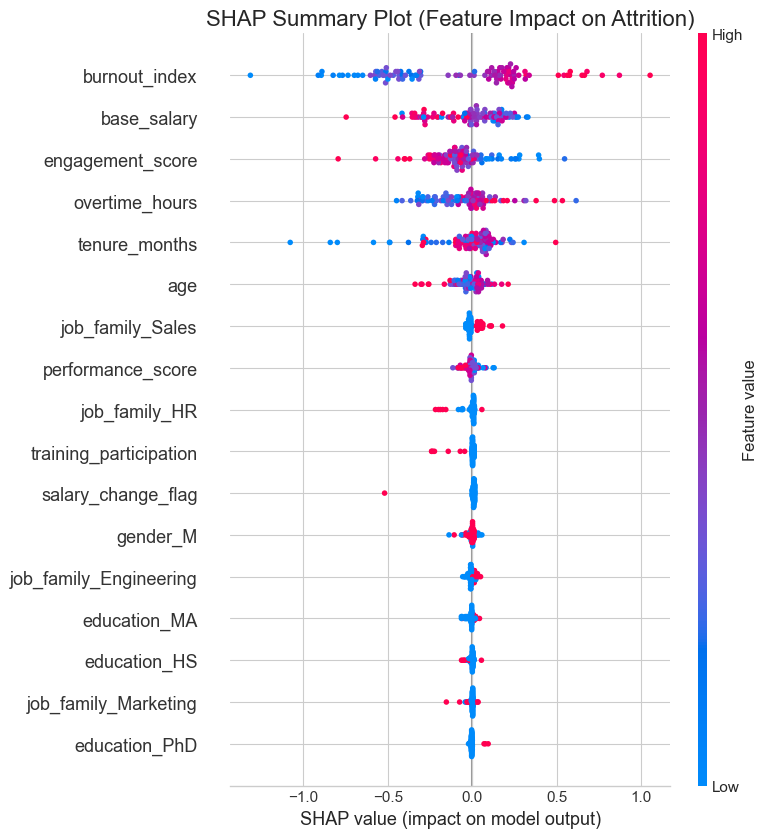


SUCCESS: All tasks completed successfully.


In [2]:
# ==========================================
# Task 2-2: 離職予測モデルとSHAPによる解釈 (完全版)
# ==========================================

# 1. ライブラリの準備
# ------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import warnings

# ★バージョン確認（ここが 2.0.3 なら成功です）
print(f"XGBoost Version: {xgb.__version__}")

# 設定
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'sans-serif' 

print("Step 1: Libraries loaded.")

# 2. データの読み込みと前処理
# ------------------------------------------
try:
    df = pd.read_csv('../data/simulated_hr_data.csv')
except FileNotFoundError:
    df = pd.read_csv('data/simulated_hr_data.csv')

# 不要な列の削除
drop_cols = ['employee_id', 'month']
model_df = df.drop(columns=drop_cols)

# カテゴリ変数のダミー変数化
model_df = pd.get_dummies(model_df, drop_first=True)

# 説明変数(X)と目的変数(y)に分割
X = model_df.drop('attrition_flag', axis=1)
y = model_df['attrition_flag']

# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Step 2: Data Prepared. Train: {X_train.shape}, Test: {X_test.shape}")

# 3. ロジスティック回帰 (ベースライン)
# ------------------------------------------
print("\nStep 3: Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]
print(f"  -> Done. AUC Score: {roc_auc_score(y_test, y_prob_lr):.3f}")

# 4. XGBoost (本番モデル)
# ------------------------------------------
print("\nStep 4: Training XGBoost...")
# バージョン変更に伴い、use_label_encoder引数は削除（警告回避）
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
print(f"  -> Done. AUC Score: {roc_auc_score(y_test, y_prob_xgb):.3f}")

# 5. SHAPによるモデル解釈 (高速化対応版)
# ------------------------------------------
print("\nStep 5: Calculating SHAP Values (Lightweight)...")

# 高速なTreeExplainerを使用
explainer = shap.TreeExplainer(xgb_model)

# 計算対象を最初の100件に絞る（これで一瞬で終わります）
X_test_sample = X_test.iloc[:100]
shap_values = explainer(X_test_sample)

# 可視化
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_sample, show=False)
plt.title("SHAP Summary Plot (Feature Impact on Attrition)", fontsize=16)
plt.show()

print("\nSUCCESS: All tasks completed successfully.")